In [1]:
import numpy as np
import matplotlib.pyplot as plt

import product_fem as pf
import fenics
import inference
rng = np.random.default_rng()

In [2]:
nx, ny = 15, 10 # mesh resolution
max_xy = (1.5, 1)
mesh = fenics.RectangleMesh(fenics.Point(0, 0), fenics.Point(*max_xy), nx-1, ny-1)
V = fenics.FunctionSpace(mesh, 'CG', 1)
W = pf.ProductFunctionSpace(V)

def random_point():
    return rng.uniform(size=2) * max_xy

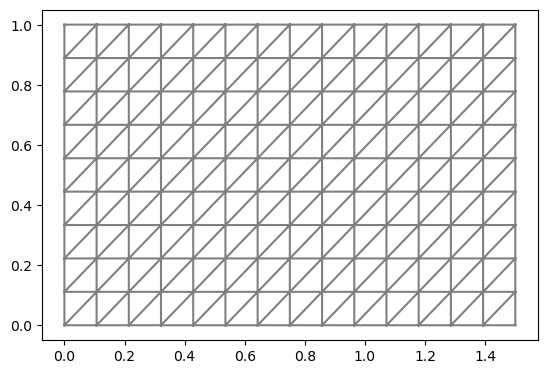

In [3]:
fenics.plot(mesh);

In [18]:
def control_array(control, b=None, sig=None):
    if b is None:
        b = (0, 0)
    if sig is None:
        sig = (0, 0, 0)
    N = int(len(control.array())/5)
    b_array = np.zeros((N, 2)) + b
    sig_array = np.zeros((N, 3)) + sig
    temp_array = np.concatenate([b_array.flatten(), sig_array.flatten()])
    return temp_array

In [5]:
def u_bdy(x, y):
    return ( (x[0] + y[0])**2 + (x[1] + y[1])**2 ) / 20
epsilon = 0.2 # 1e-2
eqn = pf.equations.HittingTimes(W, u_bdy, epsilon)

In [6]:
m_data = eqn.control
m_arr = m_data.array().copy()
u_data = eqn.solve(m_data)

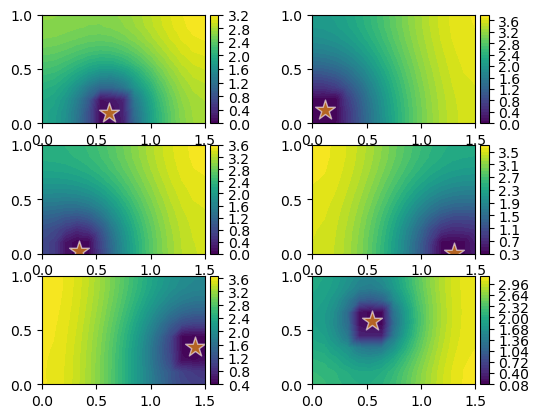

In [7]:
fig, axes = plt.subplots(3, 2)
for ax in axes.flatten():
    xy = random_point()
    u_data.plot(xy, ax=ax)

Let's make a solution that differs a little:

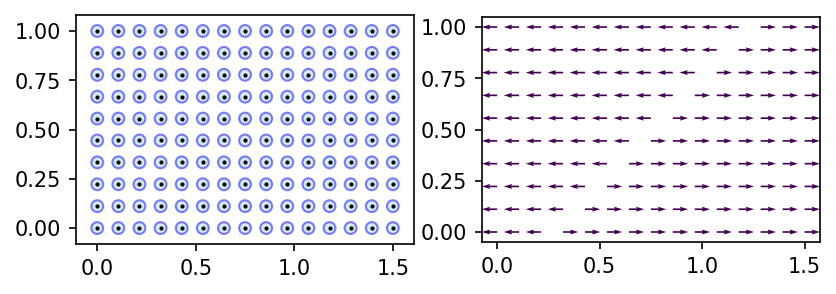

In [78]:
m = eqn.control
bb = np.ones((ny, nx)) * 1
bb[:int(ny/2),:] *= -1
true_m_array = control_array(m, b=np.column_stack([bb.flatten(), np.zeros(nx*ny)]))
m.update(true_m_array)
eqn.plot_control();

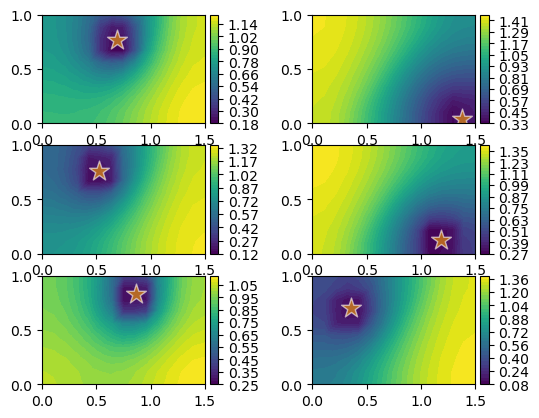

In [54]:
u = eqn.solve(m)
fig, axes = plt.subplots(3, 2)
for ax in axes.flatten():
    xy = random_point()
    u.plot(xy, ax=ax)

Plot the boundary:

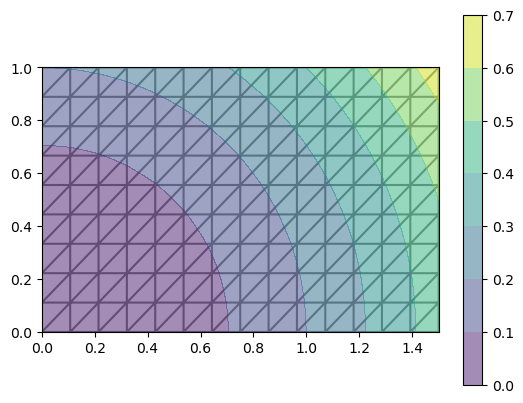

In [55]:
xlims, ylims = (0.0, max_xy[0]), (0.0, max_xy[1])
assert u((xlims[0], ylims[0]), (xlims[1], ylims[1])) > 0

X, Y = np.meshgrid(np.linspace(*xlims, 61), np.linspace(*ylims, 41))
Z = np.array([
    u((x, y), (x,y)) for x, y in zip(X.flatten(), Y.flatten())
]).reshape(X.shape)

fig = fenics.plot(mesh)[0].figure
ax = fig.axes[0]
c = ax.contourf(X, Y, Z, alpha=0.5)
ax.set_aspect(1.0)
fig.colorbar(c);

# The inference problem

In [79]:
reg = {'l2': [1e-12, 1e-12], 'smoothing': [1e-12, 1e-12]}
J = pf.LossFunctional(u, m, reg)
Jhat = pf.ReducedLossFunctional(eqn, J)
print(Jhat(m)) # loss at truth

3.673809523809524e-11


In [63]:
def Jhat(m):
    u = eqn.solve(m)
    return J(u, m)

In [82]:
# plot slice of loss surface m + h v for h passing through 0 and arbitrary v
hs = np.linspace(-1.0, 2.0, 10)
v = control_array(m, b=(1,1), sig=(0,0,0))
ms = [true_m_array + h * v for h in hs]
Js = []

for mi in ms:
    m.update(mi);
    Js.append(Jhat(m))

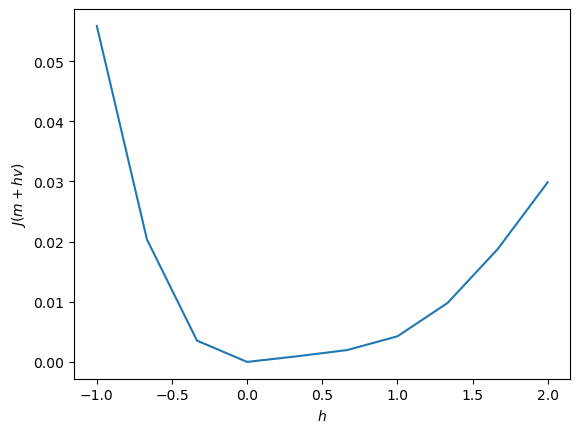

In [83]:
fig, ax = plt.subplots()

ax.plot(hs, Js)
ax.set_xlabel(r'$h$')
ax.set_ylabel(r'$J(m + h v)$')
plt.show()

# Inverse problem

In [ ]:
invp = pf.InverseProblem(eqn, J)

m_hat, results = invp.optimize(m)

loss error l2reg smoothing
0.020934202682073876 0.020934202639292805 6.712984569418051e-12 3.6068086222897185e-11
0.007936263963571433 0.007936263920588403 6.7111433072674395e-12 3.627188583995093e-11
0.007404592613436968 0.007404592570295086 6.710633547086541e-12 3.6431247394426774e-11
0.006895158466509435 0.006895158423439378 6.710701157936291e-12 3.6359354591987677e-11
0.006597204631051398 0.006597204587961472 6.7101200551745585e-12 3.637980616630801e-11
0.0060237117967089325 0.0060237117535893725 6.708957081549621e-12 3.641060261658423e-11
0.004966137077256281 0.004966137034071768 6.706708974795697e-12 3.647780422966348e-11
0.0032752856839603226 0.0032752856405796433 6.702610177463611e-12 3.667806903610584e-11
0.0020135104330966675 0.002013510389290582 6.6984567064107994e-12 3.7107628785051137e-11
0.001939651051771165 0.0019396510078717522 6.6978697053057415e-12 3.720154308597785e-11
0.001930633003829554 0.0019306329599567229 6.697964579312712e-12 3.717486648938912e-11
0.0019148827